In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy, re, nltk
#!python -m spacy download en

# # For cleaning and processing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import sent_tokenize

# !pip install gensim
# import gensim
# import gensim.corpora as corpora


# # For Modeling and Computing Accuracy

# !pip install imblearn
# !pip install delayed
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

In [2]:
df_original = pd.read_csv('Keywords_product_data.csv', index_col = 0)
df_original

,title_keywords,description_keywords,category_id
0,sunglass man woman frame drive sun glass uv block,impact scratch day time walk park drive fishin...,44
1,vintage sunglass cateye sunglass woman man fra...,quality material gradient cat eye sunglass pc ...,44
2,armour women visor,mission athlete passion design pursuit innovat...,44
3,sunglass woman man fashion shade,microfiber pouch glass cloth grfisia nbsp grfi...,44
4,feisedy sunglass woman style,feisedy retro design frame design minimalist s...,44
...,...,...,...
253923,cotton waffle robe couple spa robe bathrobe dr...,cotton couple robe amp king amp hubby amp embr...,310
253924,woman lace kimono robe lingerie mesh chemise n...,size fit woman kimono lingerie swimsuit polyes...,310
253925,pavilia women zipper robe zip front lounger,product description nbsp pavilia fleece house ...,310
253926,satin robe woman robe wedding gift,silk tie closure machine wash polyester tie cl...,310


### Data Exploration

In [3]:
#Checking the value counts of the category ids
df_original.category_id.value_counts()

293    1200
262    1200
96     1200
99     1199
14     1198
       ... 
230      47
225      47
224      44
288      42
258      40
Name: category_id, Length: 243, dtype: int64

Seems like we have 252937 records and 243 categories and some of the category ids have very less records making it an unbalanced data set.

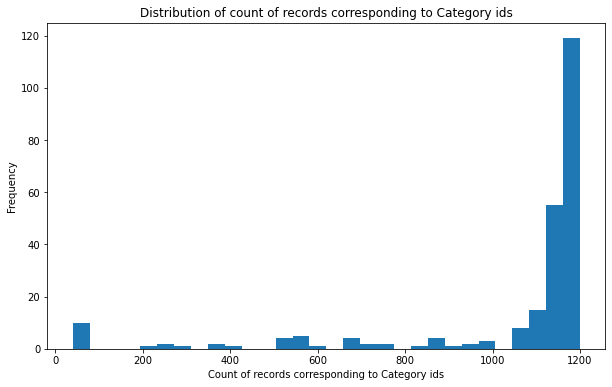

In [4]:
plt.figure(figsize = (10,6))
plt.hist(df_original.category_id.value_counts().values, bins = 30)
plt.title('Distribution of count of records corresponding to Category ids')
plt.xlabel('Count of records corresponding to Category ids')
plt.ylabel('Frequency')
plt.show()

According to the plot above we can see the distribution is left tailed so we can try to feature engineer categories with less than 800 records in them as we need to make sure to decrease the tail as well as keep around 200 categories.

### Split the data (to avoid data leakage)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_original[['title_keywords', 'description_keywords']], 
                                                    df_original['category_id'], random_state=0, test_size=0.2, 
                                                    stratify = df_original['category_id'])

### Feature Engineering

In [6]:
#Lets get a list of the category ids that have less than 640 records (because the data is split into 80/20)
cat_less = y_train.value_counts().index[y_train.value_counts().values < 640]

In [7]:
df_feature_engineer = X_train.loc[y_train[y_train.isin(cat_less)].index]
df_feature_engineer

,title_keywords,description_keywords
238510,cycle jersey woman sleeve shirt ride bike bike...,product description product detail jpojpo cycl...
231915,woman summer dress neck spaghetti strap ruffle...,size dress dress women size dress closure woma...
245505,woman sport sleeve paragraph yoga clothe suck ...,fabric polyurethane sweat colorfast deformatio...
189239,man winter snow leather boot color size,rubber shaft measure ankle premium leather boo...
200728,women leg cuff waiste vintage denim stretchy r...,fashion jean wardrobe summer feature summer sa...
...,...,...
231789,woman summer dress printing neck flowy swing s...,spring dress dress women dress closure summer ...
195542,skecher man nampa groton food service shoe,leather synthetic rubber shaft arch memory foa...
127196,creation jutti woman leather sequence shoe,leather sequence work leather india item party...
188487,kodiak man magog fashion boot,spirit kodiak boot man woman product descripti...


In [8]:
df_feature_engineer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11026 entries, 238510 to 187390
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title_keywords        11022 non-null  object
 1   description_keywords  11025 non-null  object
dtypes: object(2)
memory usage: 258.4+ KB


In [9]:
#Aggregating the keywords for the categories
df_feature_engineer['category_id'] = y_train[y_train.isin(cat_less)]
df_feature_engineer['title_keywords'] = df_feature_engineer['title_keywords'].astype('str')
df_feature_engineer_step = df_feature_engineer[['category_id', 'title_keywords']].groupby('category_id', sort=False, as_index = False).agg(' '.join)
df_feature_engineer_step

,category_id,title_keywords
0,291,cycle jersey woman sleeve shirt ride bike bike...
1,282,woman summer dress neck spaghetti strap ruffle...
2,298,woman sport sleeve paragraph yoga clothe suck ...
3,239,man winter snow leather boot color size arctix...
4,252,women leg cuff waiste vintage denim stretchy r...
5,86,tonsee woman winter hat skiing cap skull beani...
6,235,rock drone volume climbing shoe diamond moment...
7,226,men size hammer rogue carbon hand bowling shoe...
8,228,shoe man shoe camo print size fashion sneaker ...
9,197,man cotton nightshirt amp neck sleeve pajama s...


In [10]:
# Vectorizing to get an array to be fed for Latent Drichlet Allocation (Topic modelling)
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2')
vectorized_array = vectorizer.fit_transform(df_feature_engineer_step['title_keywords'].values.astype('U'))

In [11]:
# Performing LDA for topic modeling and merging the documents
lda = LatentDirichletAllocation(n_components=len(df_feature_engineer_step), random_state=0)
topics = lda.fit_transform(vectorized_array)

In [12]:
df_original.category_id.min(), df_original.category_id.max()

(3, 310)

In [13]:
dic_remap = {}
dic_remap.fromkeys(df_feature_engineer_step.category_id)
for i in range(len(topics)):
    if topics[i].max() > 0.5:
        dic_remap[df_feature_engineer_step.loc[i,'category_id']] = 320 + topics[i].argmax()
    else:
        dic_remap[df_feature_engineer_step.loc[i,'category_id']] = df_feature_engineer_step.loc[i,'category_id']

In [14]:
#Using dic_remap to remap the categories in training data
y_train.replace(dic_remap, inplace = True)
#Using dic_remap to remap the categories in test data
y_test.replace(dic_remap, inplace = True)

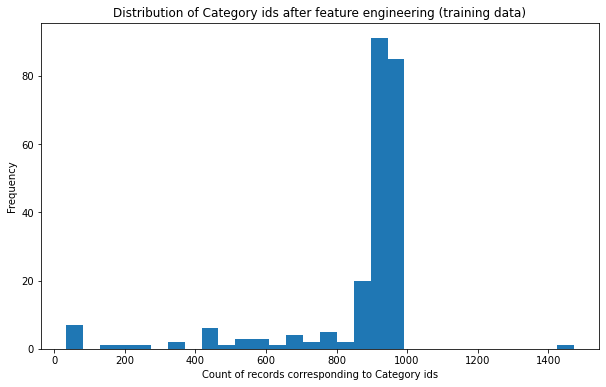

In [15]:
plt.figure(figsize = (10,6))
plt.hist(y_train.value_counts().values, bins = 30)
plt.title('Distribution of Category ids after feature engineering (training data)')
plt.xlabel('Count of records corresponding to Category ids')
plt.ylabel('Frequency')
plt.show()

The intution behind the entire process is to group similar categories together based on the cosine similarity.

Lets drop the categories with less than 640 products in the training data to deal with the imbalance

In [16]:
#Lets get a list of the category ids that have less than 640 records
cat_less_640 = y_train.value_counts().index[y_train.value_counts().values < 640]

In [17]:
X_train = X_train.drop(y_train[y_train.isin(cat_less_640)].index, axis = 0)
X_train

,title_keywords,description_keywords
194510,acko shoe pack pair shoe amp boot cover slip s...,quality quality cpe material slip size color p...
164961,winter round neck sweater man color matching s...,cotton material wool season autumn winter mode...
109586,circus sam edelman woman loafer,lining slip wearability product description fa...
75502,customize suit jacket mini skirt woman wax cot...,closure grade class fabric wax batik fabric co...
8354,woman baggy neck cotton leg jumpsuit crop pant,fabric cotton linen machine wash closure slant...
...,...,...
224004,autumn winter plaid scarf cashmere shawl winte...,shawl side wool
188045,man hunt field boot footwear sock slip rubber ...,rubber plastic material polyurethane rubber ma...
116920,women snow boot winter fur line ankle boot lad...,rubber outsole design pattern grip fearless ic...
146699,gioberti man kent lie collar sleeve tuxedo dre...,cotton polyester drawstre closure cycle front ...


In [18]:
y_train = y_train.drop(y_train[y_train.isin(cat_less_640)].index)
y_train

194510    246
164961    207
109586    151
75502     114
8354       11
         ... 
224004    275
188045    237
116920    159
146699    190
204438    255
Name: category_id, Length: 194319, dtype: int64

In [19]:
#Implementing the same process on the test data
X_test = X_test.drop(y_test[y_test.isin(cat_less_640)].index, axis = 0)
X_test

,title_keywords,description_keywords
111971,motorcycle woman boot leopard print stitch wom...,shoe woman zandalias para mujer moda bohemian ...
112565,fashion woman shoe slip leisure sneaker shoe l...,platform shoe shoe summer shoe slip shoe beach...
138565,man sleeve shirt,cotton button closure machine sleeve button sh...
116965,woman snow boot winter ankle boot fur bootie f...,winter boot boot style snow boot combination m...
164141,disney men christmas sweater,fiber closure machine wash license feature pum...
...,...,...
143168,nautica man sleeve deck polo shirt,cotton polyester button closure machine sleeve...
454,sunglass metal frame shade woman men protection,sunglass shape metal frame frame lens coating ...
121644,woman ankle strap stiletto toe sandal heel,rubber fashion design gold stiletto heel featu...
138451,man fit trouser,polyester viscose spandex zipper closure machi...


In [20]:
y_test = y_test.drop(y_test[y_test.isin(cat_less_640)].index)
y_test

111971    153
112565    153
138565    183
116965    159
164141    207
         ... 
143168    187
454        44
121644    164
138451    182
240793    293
Name: category_id, Length: 48585, dtype: int64

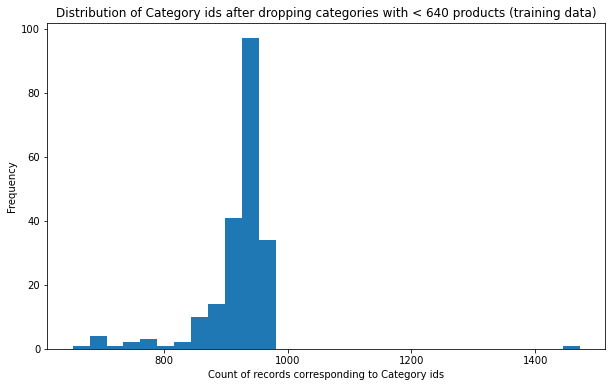

In [21]:
plt.figure(figsize = (10,6))
plt.hist(y_train.value_counts().values, bins = 30)
plt.title('Distribution of Category ids after dropping categories with < 640 products (training data)')
plt.xlabel('Count of records corresponding to Category ids')
plt.ylabel('Frequency')
plt.show()

The distribution looks better than what we had initially. We dropped 8030 records from training dataset because of the condition of more than 640 products for a category id.

### Modeling

In [22]:
X_train['merged_keywords'] = X_train['title_keywords'] + ' ' + X_train['description_keywords']
X_test['merged_keywords'] = X_test['title_keywords'] + ' ' + X_test['description_keywords']

In [23]:
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2', max_features = y_train.nunique()*10)
vectorizer.fit(X_train['merged_keywords'].values.astype('U'))
X1 = vectorizer.transform(X_train['merged_keywords'].values.astype('U'))
X1_test = vectorizer.transform(X_test['merged_keywords'].values.astype('U'))

In [24]:
##LDA for dimensionality reduction doesn't help with the reduction in overfitting
# train_dense = X1.astype(np.float32).todense()
# test_dense = X1_test.astype(np.float32).todense()
# lda = LinearDiscriminantAnalysis()
# lda.fit(train_dense, y_train)
# Xtrain_transformed = lda.transform(train_dense)
# Xtest_transformed = lda.transform(test_dense)

In [25]:
#Random forest with class weighting in bootstrap samples this is useful for imbalanced data problems
model = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight='balanced_subsample', max_samples = int(0.25*X1.shape[0]))
model.fit(X1, y_train)
predictions = model.predict(X1_test)
print('F1 score on test data from RF model: ', f1_score(y_test, predictions, average = 'micro'))
print('F1 score on train data from RF model: ', f1_score(y_train, model.predict(X1), average = 'micro'))

F1 score on test data from RF model:  0.6686631676443346
F1 score on train data from RF model:  0.8737591280317416


In [26]:
#Random forest with class weighting in bootstrap samples this is useful for imbalanced data problems
model = RandomForestClassifier(n_estimators = y_train.nunique(), random_state = 0, class_weight='balanced_subsample', max_samples = int(0.1*X1.shape[0]))
model.fit(X1, y_train)
predictions = model.predict(X1_test)
print('F1 score on test data from RF model: ', f1_score(y_test, predictions, average = 'micro'))
print('F1 score on train data from RF model: ', f1_score(y_train, model.predict(X1), average = 'micro'))

F1 score on test data from RF model:  0.6656375424513739
F1 score on train data from RF model:  0.807455781472733


In [27]:
#performing random undersampling of the majority class in each bootstrap sample
model1 = BalancedRandomForestClassifier(n_estimators = 100, random_state = 0, max_samples = int(0.25*X1.shape[0]))
model1.fit(X1, y_train)
predictions1 = model1.predict(X1_test)
print('F1 score on test data from RF model with undersampling: ', f1_score(y_test, predictions1, average = 'micro'))
print('F1 score on train data from RF model with undersampling: ', f1_score(y_train, model1.predict(X1), average = 'micro'))

F1 score on test data from RF model with undersampling:  0.6689307399403108
F1 score on train data from RF model with undersampling:  0.8702391428527317


In [28]:
#performing random undersampling of the majority class in each bootstrap sample
model1 = BalancedRandomForestClassifier(n_estimators = y_train.nunique(), random_state = 0, max_samples = int(0.1*X1.shape[0]))
model1.fit(X1, y_train)
predictions1 = model1.predict(X1_test)
print('F1 score on test data from RF model with undersampling: ', f1_score(y_test, predictions1, average = 'micro'))
print('F1 score on train data from RF model with undersampling: ', f1_score(y_train, model1.predict(X1), average = 'micro'))

F1 score on test data from RF model with undersampling:  0.6650200679221983
F1 score on train data from RF model with undersampling:  0.8063544995600018
